## **SparkML Project Report: Recipe Reviews Sentiment Analysis**

## Table of Contents

1. Introduction

2. Data Preparation and Preprocessing

3. Machine Learning Models Implementation and Evaluation

4. Analysis and Insights

5. Demonstration of SparkML Knowledge

## **1. Introduction**

### **Business Context:**

This project focuses on analyzing user feedback and reviews on recipes using Apache Spark to uncover patterns in user engagement and sentiment on a recipe-sharing platform. The purpose is to enhance recipe recommendations and improve customer satisfaction, leveraging the large-scale data processing capabilities of Spark.

### **Dataset Overview:**

The dataset is sourced from the UCI Machine Learning Repository. It consists of user-generated feedback from an online platform called Food.com that ranks recipes. The data, likely collected through web scraping , includes extensive user interactions such as comments, ratings, and reputations, making it an ideal source for detailed behavioral analysis. 
* **File Size**: 5.8 MB
* **Format**: CSV (Comma-Separated Values)
* **Number of Instances**: 18,182 rows
* **Number of Features**: 15 columns

### **Key Attributes of the Dataset:**

* **Recipe Details**: `recipe_name`, `recipe_number` (rank on the top 100 list), `recipe_code` (unique ID).
* **User Details**: `user_id`, `user_name`, `user_reputation`.
* **Review Metadata**: `comment_id`, `created_at` (Unix timestamp), `reply_count`, `thumbs_up`, `thumbs_down`, `stars` (rating from 1 to 5, with 0 indicating no rating).
* **Textual Data**: The `text` column contains the full content of the user comment, which may include reviews or feedback on the recipe.

### **Purpose:**

The project focuses on exploring a rich dataset of recipe reviews and user interactions sourced from an online platform, making it highly relevant for a range of practical applications. The primary purpose is to leverage this data for sentiment analysis, user behavior modeling, and trend identification using advanced data processing techniques. By analyzing attributes like thumbs_up, stars, user reputation, and textual feedback, the project aims to uncover user preferences and engagement patterns. Additionally, the dataset supports the development of robust recommendation systems tailored to user tastes and preferences. Researchers can utilize this dataset for machine learning tasks, including text classification and user interaction modeling. The project demonstrates the use of PySpark and NLP techniques to extract insights, highlighting its value in improving user experience, understanding content engagement, and developing data-driven strategies in the domain of online recipe platforms.

---

## **2. Data Preparation and Preprocessing**

### **Initialize Spark Session**

This step initializes a Spark session, which serves as the foundation for running a PySpark application.

In [2]:
import findspark
findspark.init()

 
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .master("local[4]") \
    .appName("Recipe Reviews EDA") \
    .enableHiveSupport() \
    .getOrCreate()

# Load the data
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/15 16:22:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/15 16:23:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


This step extracts and prints the port number of Spark's Web UI by parsing the URL from `sparkContext`. The Web UI allows users to monitor Spark job performance and execution. The extracted port is displayed, enabling users to access the UI in a browser for debugging and monitoring tasks.

In [3]:
spark_session_port = spark.sparkContext.uiWebUrl.split(":")[-1]
print("Spark Session WebUI Port: " + spark_session_port)


Spark Session WebUI Port: 4041


This line sets the Spark logging level to `ERROR`, ensuring that only error messages are displayed. It hides less critical logs, such as `INFO` and `WARNING`, to reduce clutter in the console output. If detailed logs are needed for debugging, the log level can be changed to `INFO` or `WARN`.

In [4]:
# this will set the log level to ERROR. This will hide the INFO or WARNING messages that are printed out by default. If you want to see them, set this to INFO or WARN.
sc.setLogLevel("ERROR")

We have executed the SQL command `SHOW DATABASES` using Spark's SQL interface to list all available databases in the current Spark environment.

In [5]:
databases_df=spark.sql("show databases")
databases_df.show()

+---------+
|namespace|
+---------+
|  default|
+---------+



We have executed the SQL command `SHOW TABLES` to list all tables in the current database or Spark environment.

In [6]:
tables_df = spark.sql("show tables")
tables_df.show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
+---------+---------+-----------+



### **Load and Explore Dataset**

The dataset, stored as a CSV file, is loaded into a Spark DataFrame. The `header=True` option ensures the first row is treated as column names, and `inferSchema=True` allows Spark to automatically determine the data types of each column. 

In [7]:
df = spark.read.csv('Recipe Reviews and User Feedback Dataset.csv', header=True, inferSchema=True);

# display the first 5 rows of the dataframe
df.show(5)


+---+-------------+-----------+------------------+--------------------+--------------+----------+---------------+----------+-----------+---------+-----------+-----+----------+--------------------+
|_c0|recipe_number|recipe_code|       recipe_name|          comment_id|       user_id| user_name|user_reputation|created_at|reply_count|thumbs_up|thumbs_down|stars|best_score|                text|
+---+-------------+-----------+------------------+--------------------+--------------+----------+---------------+----------+-----------+---------+-----------+-----+----------+--------------------+
|  0|          001|      14299|Creamy White Chili|sp_aUSaElGf_14299...|u_9iFLIhMa8QaG|   Jeri326|              1|1665619889|          0|        0|          0|    5|       527|I tweaked it a li...|
|  1|          001|      14299|Creamy White Chili|sp_aUSaElGf_14299...|u_Lu6p25tmE77j|   Mark467|             50|1665277687|          0|        7|          0|    5|       724|Bush used to have...|
|  2|          

`.printSchema()` provides a detailed view of the dataset's structure, including column names and their inferred types.

In [8]:
# Display the schema of the DataFrame
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- recipe_number: string (nullable = true)
 |-- recipe_code: string (nullable = true)
 |-- recipe_name: string (nullable = true)
 |-- comment_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_reputation: string (nullable = true)
 |-- created_at: integer (nullable = true)
 |-- reply_count: integer (nullable = true)
 |-- thumbs_up: integer (nullable = true)
 |-- thumbs_down: integer (nullable = true)
 |-- stars: integer (nullable = true)
 |-- best_score: integer (nullable = true)
 |-- text: string (nullable = true)



### **Data Type Casting**

To prepare the data for analysis, specific columns are cast into appropriate data types. For example, `recipe_number` and `thumbs_up` are cast to `IntegerType` to ensure they can participate in arithmetic operations, and `created_at` is cast to `TimestampType` for time-based computations. Casting ensures data consistency and avoids errors in subsequent steps.


In [9]:
from pyspark.sql.types import IntegerType, TimestampType
from pyspark.sql.functions import col

# Cast columns to the appropriate types
df = df.withColumn("recipe_number", col("recipe_number").cast(IntegerType())) \
       .withColumn("recipe_code", col("recipe_code").cast(IntegerType())) \
       .withColumn("user_reputation", col("user_reputation").cast(IntegerType())) \
       .withColumn("created_at", col("created_at").cast(TimestampType())) \
       .withColumn("reply_count", col("reply_count").cast(IntegerType())) \
       .withColumn("thumbs_up", col("thumbs_up").cast(IntegerType())) \
       .withColumn("thumbs_down", col("thumbs_down").cast(IntegerType())) \
       .withColumn("stars", col("stars").cast(IntegerType())) \
       .withColumn("best_score", col("best_score").cast(IntegerType()))


# Verify the schema
df.printSchema()


root
 |-- _c0: string (nullable = true)
 |-- recipe_number: integer (nullable = true)
 |-- recipe_code: integer (nullable = true)
 |-- recipe_name: string (nullable = true)
 |-- comment_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_reputation: integer (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- reply_count: integer (nullable = true)
 |-- thumbs_up: integer (nullable = true)
 |-- thumbs_down: integer (nullable = true)
 |-- stars: integer (nullable = true)
 |-- best_score: integer (nullable = true)
 |-- text: string (nullable = true)



In [10]:
# Rename columns for better clarity if needed
df = df.withColumnRenamed("_c0", "id") \
       .withColumnRenamed("created_at", "review_timestamp") \
       .withColumnRenamed("stars", "rating") \
       .withColumnRenamed("text", "review_comments")


In [11]:
from pyspark.sql.functions import year, month, dayofmonth, hour, dayofweek

# Extract year, month, day, hour, and weekday
df = df.withColumn("year", year(df["review_timestamp"])) \
       .withColumn("month", month(df["review_timestamp"])) \
       .withColumn("day", dayofmonth(df["review_timestamp"])) \
       .withColumn("hour", hour(df["review_timestamp"])) \
       .withColumn("day_of_week", dayofweek(df["review_timestamp"]))  # Monday = 1, Sunday = 7

### **Data Cleaning**

This step checks for missing data in all columns and fills non-critical fields, such as `rating` and `user_reputation`, with default values like 0. To maintain data quality, rows with missing values in important columns like `recipe_number` and `review_comments` are removed, ensuring the dataset is clean and ready for analysis.

In [12]:
from pyspark.sql.functions import when, count, isnan

# Check for missing values in each column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Handle missing values 
df = df.na.fill({ "rating" : 0, "user_reputation": 0, "thumbs_up":0, "thumbs_up":0})
# Drop rows with nulls in critical columns
df = df.na.drop(subset=["recipe_number", "recipe_code", "user_id", "comment_id", "review_comments"])

+---+-------------+-----------+-----------+----------+-------+---------+---------------+----------------+-----------+---------+-----------+------+----------+---------------+----+-----+---+----+-----------+
| id|recipe_number|recipe_code|recipe_name|comment_id|user_id|user_name|user_reputation|review_timestamp|reply_count|thumbs_up|thumbs_down|rating|best_score|review_comments|year|month|day|hour|day_of_week|
+---+-------------+-----------+-----------+----------+-------+---------+---------------+----------------+-----------+---------+-----------+------+----------+---------------+----+-----+---+----+-----------+
|  0|           86|         86|         74|        77|     80|       83|             86|              86|         86|       86|         86|    86|        86|             86|  86|   86| 86|  86|         86|
+---+-------------+-----------+-----------+----------+-------+---------+---------------+----------------+-----------+---------+-----------+------+----------+---------------+---

In [28]:
df.toPandas().to_csv('recipe_recommendation.csv', index=False)

The data is saved as a table named "recipe_reviews," replacing any existing table with the same name. This ensures the dataset is readily available for SQL-based queries within the Spark environment, making it easier to perform analysis and retrieve insights efficiently.

In [45]:
# df.write.saveAsTable("recipe_reviews", mode='overwrite')

A temporary view named "recipe_reviews" is created from the DataFrame. This allows SQL queries to be performed directly on the view within the Spark environment, enabling seamless integration of SQL operations with Spark’s powerful data processing capabilities. Temporary views are session-specific and do not persist after the session ends.

In [46]:
# Create a temporary view for SQL operations
df.createOrReplaceTempView("recipe_reviews")

Descriptive statistics are calculated for selected numerical columns such as `rating`, `user_reputation`, `thumbs_up`, `thumbs_down`, and `reply_count`. These statistics include metrics like count, mean, standard deviation, minimum, and maximum values, providing a summary of the data distribution and highlighting key patterns or anomalies in these columns.

In [47]:
## Descriptive Statistics
desc_stats_df = df.describe(["rating", "user_reputation", "thumbs_up", "thumbs_down", "reply_count"])
desc_stats_df.show()


+-------+------------------+------------------+------------------+------------------+--------------------+
|summary|            rating|   user_reputation|         thumbs_up|       thumbs_down|         reply_count|
+-------+------------------+------------------+------------------+------------------+--------------------+
|  count|             18182|             18182|             18182|             18182|               18182|
|   mean|  4.28880211197888|2.1596084039159607|1.0892641073589264|0.5493345066549334|0.014629853701462985|
| stddev|1.5447863581965293|10.014666150794339| 4.201003572820717|3.4701239835681577| 0.13797398993046833|
|    min|                 0|                 0|                 0|                 0|                   0|
|    max|                 5|               520|               106|               126|                   3|
+-------+------------------+------------------+------------------+------------------+--------------------+



This step analyzes the relationship between `user_reputation`, `thumbs_up`, and `rating` to identify potential dependencies. A heatmap is used to visualize the correlation values, making it easier to understand the strength and direction of relationships. This insight helps in determining how these factors influence each other in the dataset.

                 user_reputation  thumbs_up    rating
user_reputation         1.000000   0.057863  0.015554
thumbs_up               0.057863   1.000000 -0.050884
rating                  0.015554  -0.050884  1.000000


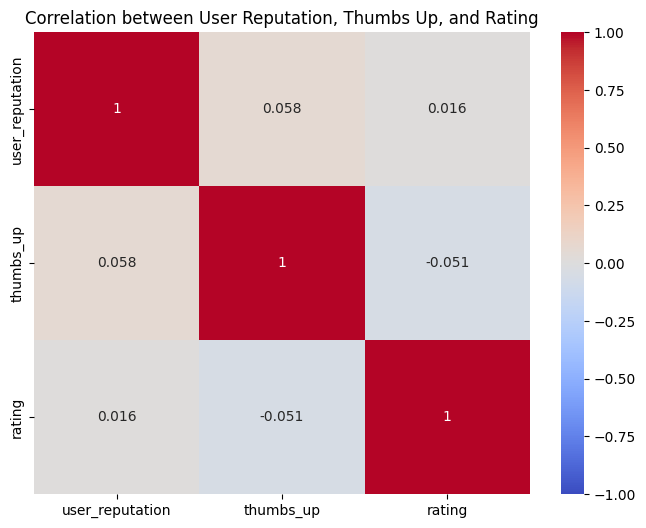

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation analysis between user_reputation, thumbs_up, and rating
correlation_df = df.select("user_reputation", "thumbs_up", "rating").toPandas()

# Compute correlations between user_reputation, thumbs_up, and rating
correlations = correlation_df.corr()
print(correlations)

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between User Reputation, Thumbs Up, and Rating")
plt.show()

The heatmap visualizes the correlation between `user_reputation`, `thumbs_up`, and `rating`. The values show weak correlations among all variables:

- `user_reputation` and `thumbs_up` have a low positive correlation (0.058).
- `rating` shows a very slight negative correlation with `thumbs_up` (-0.051) and minimal positive correlation with `user_reputation` (0.016).

This suggests no strong dependency between these factors.

In [49]:
# Query to see distribution of star ratings
top_recipes_df = spark.sql("""
    SELECT recipe_name, AVG(rating) AS average_rating
    FROM recipe_reviews
    GROUP BY recipe_name
    ORDER BY average_rating DESC
    LIMIT 20
""")

top_recipes_df.show()

+--------------------+------------------+
|         recipe_name|    average_rating|
+--------------------+------------------+
|Rustic Italian To...| 4.731343283582089|
|        Corn Pudding|4.7114093959731544|
|       Pumpkin Bread| 4.645348837209302|
|   Macaroni Coleslaw| 4.633507853403142|
|Zucchini Pizza Ca...| 4.632530120481928|
|Special Banana Nu...| 4.609022556390977|
|Flavorful Chicken...| 4.608695652173913|
| Traditional Lasagna| 4.605072463768116|
|Comforting Chicke...|               4.6|
|Best Ever Banana ...| 4.587426326129666|
|   Cheeseburger Soup| 4.576551724137931|
|Ham and Swiss Sli...|4.5701754385964914|
|   Buttery Cornbread| 4.537634408602151|
|    Cauliflower Soup| 4.530864197530864|
| Stuffed Pepper Soup| 4.527027027027027|
|Amish Breakfast C...|4.5266272189349115|
|Asian Chicken Thighs|4.5256410256410255|
|Banana Bars with ...|  4.51937984496124|
|Favorite Chicken ...|4.5139240506329115|
| Frosted Banana Bars| 4.493670886075949|
+--------------------+------------

This query calculates the average rating for each recipe by grouping the data based on the recipe name. It then orders the results in descending order of the average rating, highlighting the top 20 recipes with the highest average ratings. This helps identify the most highly-rated recipes in the dataset, offering insights into user preferences.

The results show the top 20 recipes with the highest average ratings from the `recipe_reviews` table. The most loved recipe is *Rustic Italian Tortellini Soup* with an average rating of 4.73, followed by *Corn Pudding* and *Pumpkin Bread.* The list includes a mix of savory and sweet dishes, such as *Macaroni Coleslaw, Comforting Chicken Noodle Soup,* and *Special Banana Nut Bread.* Banana-based recipes appear several times, showing their popularity. Many dishes, like *Traditional Lasagna* and *Stuffed Pepper Soup,* are comfort foods, which suggests people enjoy familiar, hearty meals. This data highlights what recipes people rate highly, and further study could look at trends based on ingredients, seasons, or user preferences.

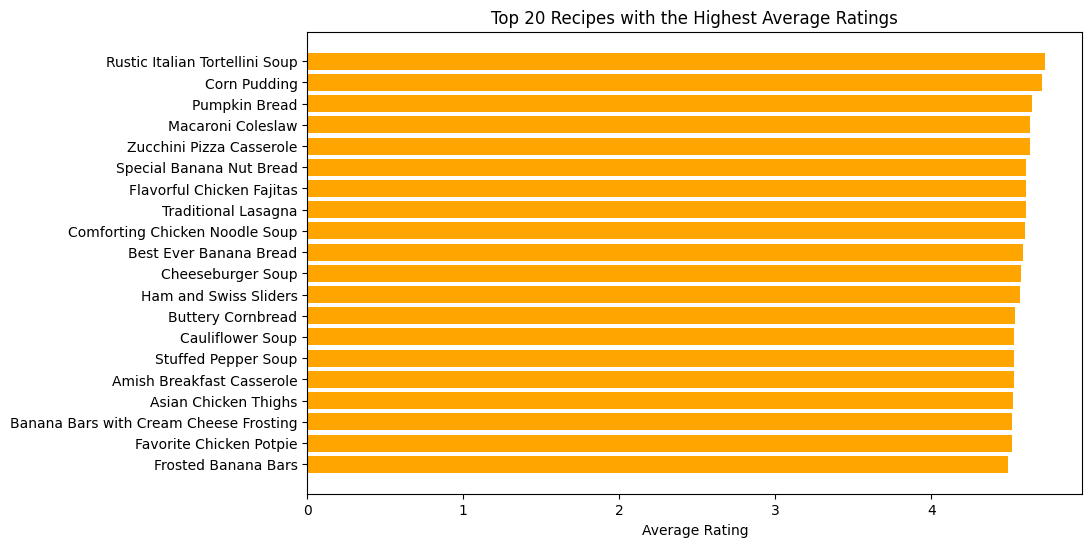

In [50]:
top_recipes_df = top_recipes_df.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(top_recipes_df['recipe_name'], top_recipes_df['average_rating'], color='orange')
plt.xlabel('Average Rating')
plt.title('Top 20 Recipes with the Highest Average Ratings')
plt.gca().invert_yaxis()  # To have the highest rating at the top
plt.show()

The visualization displays the top 20 recipes with the highest average ratings. Each bar represents a recipe, and its length corresponds to the average user rating. The chart highlights popular and highly rated recipes, with the most favored ones like `Rustic Italian Tortellini Soup` appearing at the top for user satisfaction and engagement, while `Frosted Banana Bars` is at the bottom.

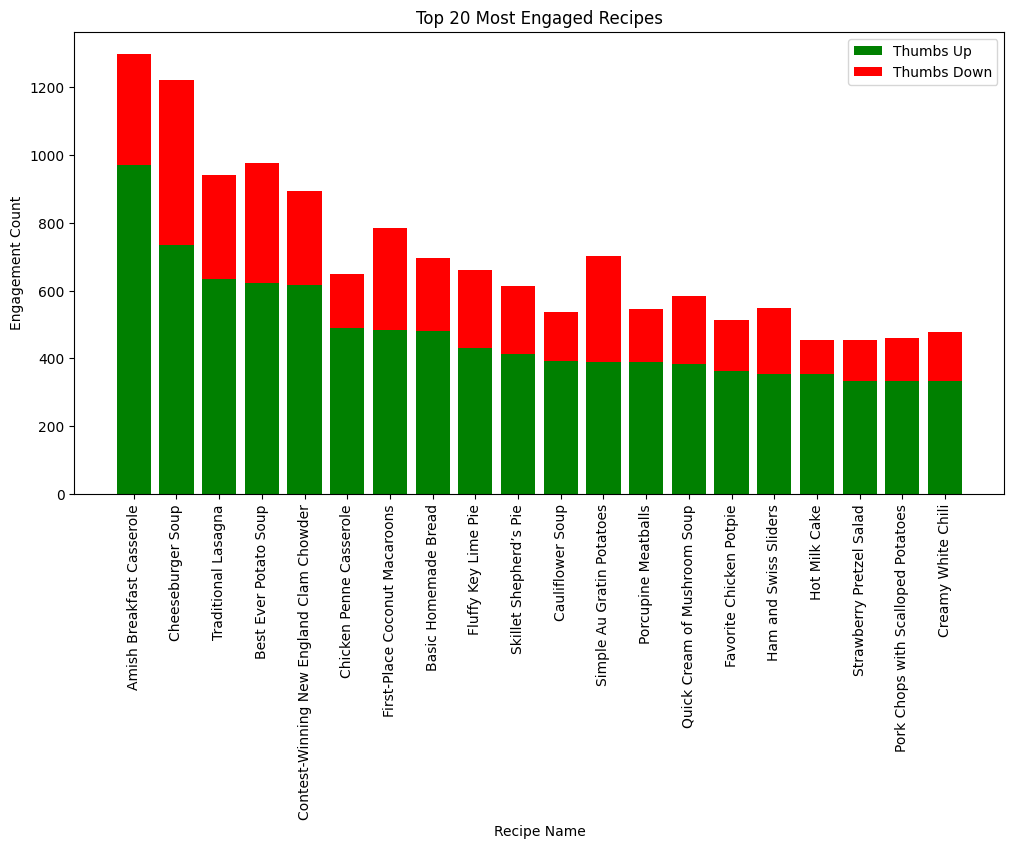

In [22]:
# Identify top recipes based on thumbs up and thumbs down
engaged_recipes_df = spark.sql("""
SELECT recipe_name, 
    SUM(thumbs_up) AS total_thumbs_up, 
    SUM(thumbs_down) AS total_thumbs_down, 
    AVG(rating) AS avg_rating
    FROM recipe_reviews
    GROUP BY recipe_name
    ORDER BY total_thumbs_up DESC
    LIMIT 20
""")

# Convert to Pandas for visualization
engaged_recipes_df = engaged_recipes_df.toPandas()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(engaged_recipes_df['recipe_name'], engaged_recipes_df['total_thumbs_up'], label='Thumbs Up', color='green')
plt.bar(engaged_recipes_df['recipe_name'], engaged_recipes_df['total_thumbs_down'], label='Thumbs Down', color='red', bottom=engaged_recipes_df['total_thumbs_up'])
plt.xlabel('Recipe Name')
plt.ylabel('Engagement Count')
plt.title('Top 20 Most Engaged Recipes')
plt.xticks(rotation=90)
plt.legend()
plt.show()

The chart displays the top 20 most engaged recipes based on the total number of thumbs-up and thumbs-down votes. *Amish Breakfast Casserole* stands out with the highest engagement, receiving significantly more thumbs-up votes than thumbs-down votes. *Cheeseburger Soup* follows with high engagement but a more balanced ratio of positive to negative feedback. Overall, most recipes show a higher proportion of thumbs-up, indicating they are well-received by users. Recipes with taller bars, like *Amish Breakfast Casserole* and *Cheeseburger Soup,* demonstrate strong user interaction and popularity. This visualization provides insights into which recipes attract the most user feedback and engagement.

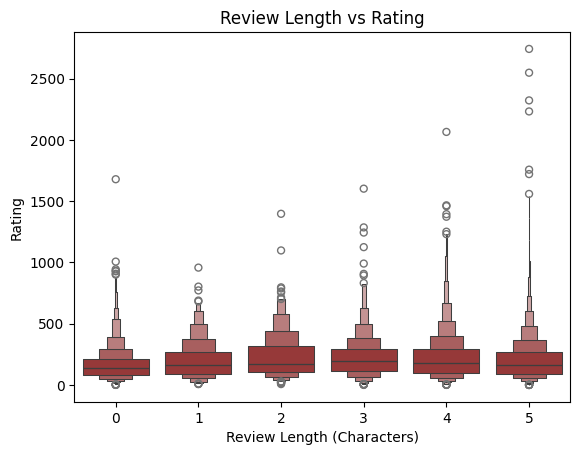

In [23]:
from pyspark.sql.functions import length

# Length of review text vs rating
df = df.withColumn("review_length", length(col("review_comments")))
sns.boxenplot(data=df.toPandas(), x='rating', y='review_length', color='brown')
plt.title('Review Length vs Rating')
plt.xlabel('Review Length (Characters)')
plt.ylabel('Rating')
plt.show()

The chart shows the relationship between the length of review comments (in characters) and the rating provided by users. Each box corresponds to a specific rating from 1 to 5, displaying the range of review lengths associated with that rating. Most reviews cluster around similar lengths for each rating, with outliers extending to significantly longer comments. Ratings of 4 and 5 tend to have slightly longer reviews on average, indicating that users who give higher ratings might write more detailed feedback. In contrast, lower ratings (1 or 2) also show a wide variation in review lengths but with fewer extreme outliers. Overall, the plot highlights the diversity in review lengths across different ratings, showing no strong correlation but suggesting that detailed reviews are more common with positive feedback.

In [24]:
# !pip install wordcloud

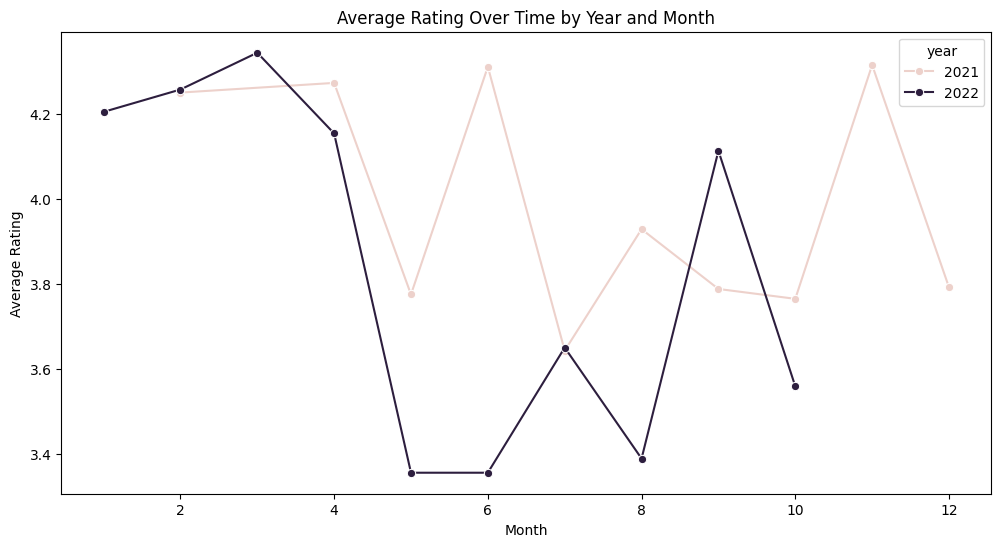

In [25]:
##Ratings over time
trends_df = spark.sql("""
    SELECT year, month, AVG(rating) AS avg_rating
    FROM recipe_reviews
    GROUP BY year, month
    ORDER BY year, month
""")

# Convert to Pandas for visualization
temporal_trends_pd = trends_df.toPandas()

# Plot temporal trends for average ratings over months
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x="month", y="avg_rating", data=temporal_trends_pd, marker="o", hue="year")
plt.title("Average Rating Over Time by Year and Month")
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.show()

The chart shows the trend of average recipe ratings over time, grouped by year and month. The two lines represent ratings for 2021 and 2022, with markers indicating the monthly averages. Ratings in 2021 generally remained steady, peaking in certain months like May and December, suggesting higher user satisfaction during those times. In 2022, the ratings exhibited more fluctuation, with a sharp decline around May followed by a recovery in the later months. The graph highlights seasonal or time-based variations in user feedback, with potential influences from seasonal recipes or changes in user engagement. The comparison between the years suggests that user ratings can vary significantly depending on the time of year.

In [26]:
# !pip install TextBlob

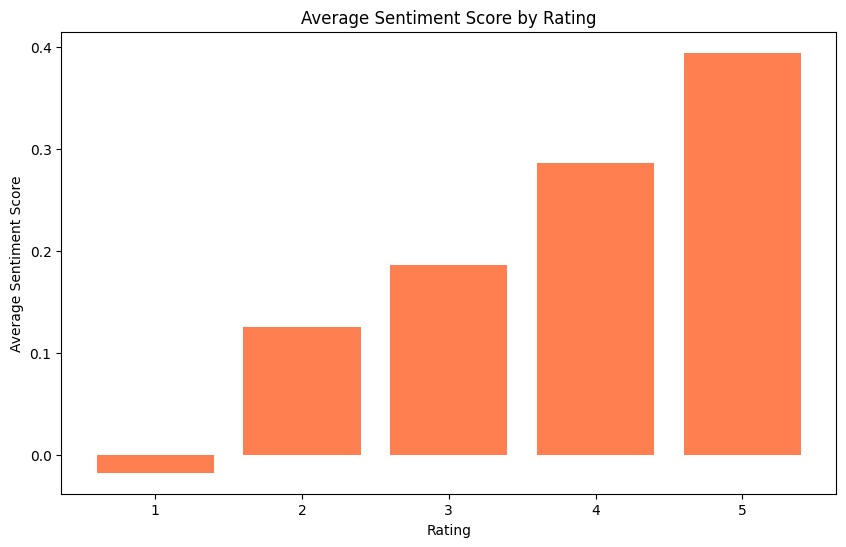

In [51]:
from textblob import TextBlob
import matplotlib.pyplot as plt

# Convert the DataFrame to an RDD
comments_rdd = df.select("review_comments", "rating").dropna().rdd

# Filter out ratings with a value of 0
comments_rdd_filtered = comments_rdd.filter(lambda row: row["rating"] != 0)

# Map each comment to its sentiment score
sentiment_rdd = comments_rdd_filtered.map(lambda row: (row["rating"], TextBlob(row["review_comments"]).sentiment.polarity))


# Map to (rating, (sentiment_score, 1)) for counting and summing scores
sentiment_count_rdd = sentiment_rdd.mapValues(lambda sentiment: (sentiment, 1))

# Reduce by key to sum up the sentiment scores and counts for each rating
sum_counts_by_rating = sentiment_count_rdd.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

# Calculate the average sentiment for each rating
avg_sentiment_by_rating = sum_counts_by_rating.mapValues(lambda x: x[0] / x[1]).collect()

# Convert to a sorted list for plotting
avg_sentiment_by_rating = sorted(avg_sentiment_by_rating, key=lambda x: x[0])

# Separate ratings and sentiment values for plotting
ratings, avg_sentiments = zip(*avg_sentiment_by_rating)

# Plot the average sentiment by rating
plt.figure(figsize=(10, 6))
plt.bar(ratings, avg_sentiments, color='coral')
plt.xlabel("Rating")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment Score by Rating")
plt.show()


The bar chart illustrates the average sentiment score of reviews for each rating, ranging from 1 to 5. The sentiment score, derived from analyzing the tone of the reviews, indicates how positive or negative the language is. Ratings of 5 have the highest average sentiment score, showing that reviews with this rating are the most positive. Ratings of 4 also have a high average sentiment score, while ratings of 3 have a neutral sentiment. Ratings of 2 and 1 display lower sentiment scores, with rating 1 being the most negative. This chart highlights a strong correlation between higher ratings and more positive sentiment in reviews.

In [28]:
df.printSchema()


root
 |-- id: string (nullable = true)
 |-- recipe_number: integer (nullable = true)
 |-- recipe_code: integer (nullable = true)
 |-- recipe_name: string (nullable = true)
 |-- comment_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_reputation: integer (nullable = false)
 |-- review_timestamp: timestamp (nullable = true)
 |-- reply_count: integer (nullable = true)
 |-- thumbs_up: integer (nullable = false)
 |-- thumbs_down: integer (nullable = true)
 |-- rating: integer (nullable = false)
 |-- best_score: integer (nullable = true)
 |-- review_comments: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- review_length: integer (nullable = true)



In [29]:

from textblob import TextBlob
from pyspark.sql import SparkSession
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
import nltk

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') 

# Initialize NLTK tools
stop_words = set(stopwords.words("english"))

# Add custom stopwords for unwanted words
custom_stopwords = {"good", "great", "easy", "much", "way", "next", "little", "time", "recipe", "delicious"}
stop_words.update(custom_stopwords)

lemmatizer = WordNetLemmatizer()

# Function to clean and preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and single characters
    text = re.sub(r'\b\w{1}\b', '', text)  # Remove single letters
    text = re.sub(r'\d+', '', text)         # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)      # Remove special characters

    # Tokenize text and filter by POS tags for nouns only
    blob = TextBlob(text)
    tokens = [word for word, pos in blob.tags if pos in ('NN', 'NNS')]

    # Remove stopwords and lemmatize each word
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens


# Initialize Spark session
spark = SparkSession.builder \
    .appName("Noun and Adjective Count by Rating") \
    .getOrCreate()

# Convert DataFrame to an RDD with (rating, comment) pairs
comments_rdd = df.select("review_comments", "rating").dropna().rdd

# Preprocess and extract features for each comment
processed_comments_rdd = comments_rdd.map(lambda row: (row["rating"], preprocess_text(row["review_comments"])))

# Flatten the list of features and map each to (rating, feature) pairs
flattened_features_rdd = processed_comments_rdd.flatMap(lambda x: [(x[0], feature) for feature in x[1]])

# Count each noun and adjective for each rating
feature_counts_rdd = flattened_features_rdd.map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda a, b: a + b)

# Transform back to (rating, (feature, count)) format for easy grouping
feature_counts_by_rating = feature_counts_rdd.map(lambda x: (x[0][0], (x[0][1], x[1])))

# Group features by rating and get top 10 for each rating
top_features_by_rating = feature_counts_by_rating.groupByKey().mapValues(lambda features: sorted(features, key=lambda x: -x[1])[:10])

# Collect and display top 10 features for each rating
top_features = top_features_by_rating.collect() 
for rating, features in sorted(top_features):
    print(f"Top features for rating {rating}:")
    for feature, count in features:
        print(f"  {feature}: {count}")
    print("\n")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sudhe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sudhe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sudhe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Top features for rating 0:
  family: 165
  cake: 147
  cup: 144
  sugar: 141
  pie: 119
  bread: 100
  cream: 99
  soup: 96
  flour: 96
  flavor: 92


Top features for rating 1:
  cake: 36
  taste: 30
  pie: 30
  ingredient: 27
  flavor: 25
  review: 23
  bread: 22
  waste: 21
  sauce: 19
  soup: 19


Top features for rating 2:
  flavor: 46
  cake: 40
  taste: 33
  sugar: 27
  sauce: 25
  pie: 24
  soup: 21
  crust: 21
  something: 20
  cream: 20


Top features for rating 3:
  flavor: 90
  taste: 74
  sugar: 74
  soup: 66
  sauce: 62
  cup: 52
  cream: 50
  cake: 45
  cheese: 41
  family: 40


Top features for rating 4:
  flavor: 229
  sauce: 213
  sugar: 189
  cup: 187
  soup: 177
  cream: 173
  cake: 165
  cheese: 161
  family: 143
  taste: 134


Top features for rating 5:
  family: 2194
  soup: 1369
  cake: 1351
  cup: 1169
  husband: 1167
  bread: 1128
  cream: 1111
  sugar: 1080
  chicken: 1055
  sauce: 1046




This analysis extracts the most frequently mentioned nouns in reviews for each rating. For example, in reviews rated 0, common terms include "family," "cake," and "cup," reflecting users' frequent discussion topics in low-rated reviews. In higher-rated reviews, terms like "chicken" and "sauce" dominate, indicating themes associated with positive feedback. This helps understand user preferences and areas of improvement based on review content.

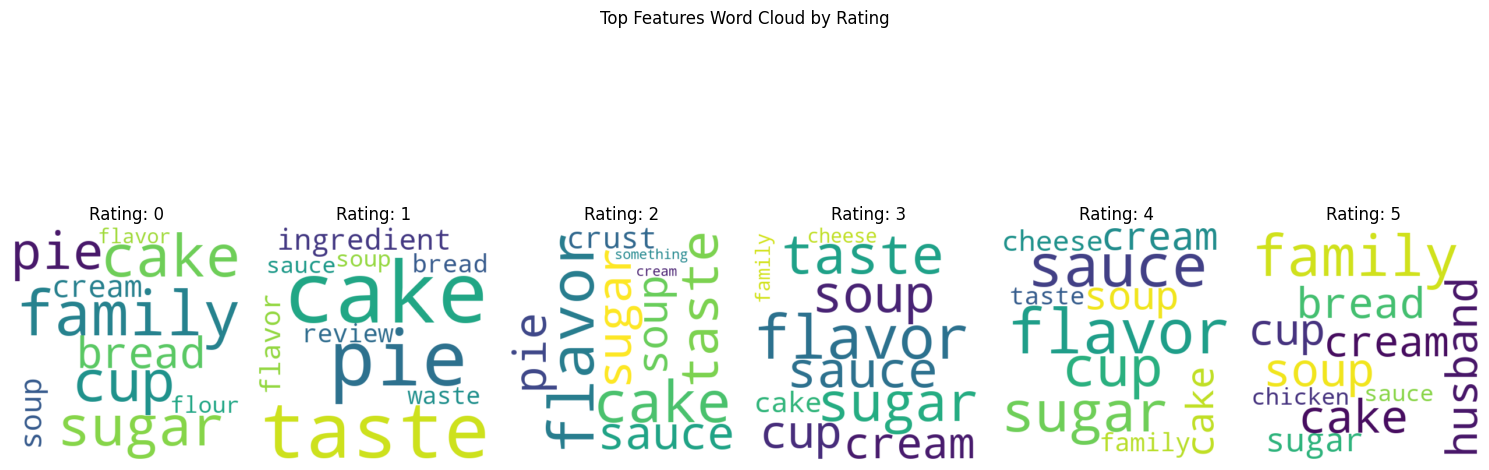

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Group features by rating and get top 10 for each rating
top_features_by_rating = feature_counts_by_rating.groupByKey().mapValues(lambda features: sorted(features, key=lambda x: -x[1])[:10])

# Collect the top features for each rating
top_features = top_features_by_rating.collect()

# Determine the number of ratings
num_ratings = len(top_features)

# Set up subplots for each rating
fig, axs = plt.subplots(1, num_ratings, figsize=(15, 6))
fig.suptitle("Top Features Word Cloud by Rating")

# Loop over each rating and generate word cloud
for i, (rating, features) in enumerate(sorted(top_features)):
    # Convert features to a dictionary for WordCloud
    word_freq = {feature: count for feature, count in features}
    
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=400, background_color="white").generate_from_frequencies(word_freq)
    
    # Display the word cloud in the subplot
    axs[i].imshow(wordcloud, interpolation="bilinear")
    axs[i].axis("off")
    axs[i].set_title(f"Rating: {rating}")

# Adjust layout and display
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


The word cloud visualization highlights the top nouns mentioned in reviews for each rating. It provides a clear representation of user sentiment and preferences across different ratings. For lower ratings, terms like "taste" and "waste" dominate, reflecting dissatisfaction. In contrast, higher ratings frequently mention positive terms like "family," "flavor," and "chicken," indicating enjoyment and satisfaction with the recipes. This helps to identify patterns in user feedback effectively.

---

## 3. **Recepie Recommendation System based on transformer**

In [29]:
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from tqdm import tqdm
from pyspark.sql.types import ArrayType, FloatType

device = "cuda" if torch.cuda.is_available() else "cpu"
 
# Convert the Spark DataFrame to a Pandas DataFrame for processing
df_pd = df.toPandas()

# Load a pre-trained Sentence Transformer model and move it to the GPU if available
model = SentenceTransformer('all-MiniLM-L6-v2').to(device)

# Generate embeddings for each review comment using the GPU
tqdm.pandas(desc="Generating Embeddings on GPU")
df_pd['embedding'] = df_pd['review_comments'].progress_apply(
    lambda comment: [float(x) for x in model.encode(comment, device=device).astype(float)]
)

# Convert the Pandas DataFrame back to a Spark DataFrame
df_embeddings = spark.createDataFrame(df_pd)

# User input for finding similar recipes (moved to GPU for embedding generation)
user_input = "I love easy and tasty white chili recipes with a bit of spice."
user_embedding = [float(x) for x in model.encode([user_input], device=device)[0].astype(float)]

# Define a UDF to calculate cosine similarity between the user's input and the recipe embeddings
def calculate_similarity(embedding_row, user_embedding):
    try:
        if embedding_row is None or len(embedding_row) == 0:
            return 0.0
        recipe_embedding = torch.tensor(embedding_row).to(device).reshape(1, -1)
        user_embedding_tensor = torch.tensor(user_embedding).to(device).reshape(1, -1)
        similarity = cosine_similarity(recipe_embedding.cpu().numpy(), user_embedding_tensor.cpu().numpy())[0][0]
        return float(similarity)
    except Exception as e:
        print("Error in UDF:", e)
        return None

# Register the UDF for calculating similarity
similarity_udf = udf(lambda x: calculate_similarity(x, user_embedding), FloatType())

# Apply the UDF to calculate similarity scores for each recipe
df_embeddings = df_embeddings.withColumn("similarity", similarity_udf(df_embeddings["embedding"]))

# Select top 5 recipes based on similarity score
top_recipes_df = (df_embeddings
                    .select("recipe_name", "review_comments", "similarity")
                    .groupBy("recipe_name")
                    .avg("similarity")
                    .orderBy(col("avg(similarity)").desc())
                    .limit(5))

# Display the top recommended recipes
top_recipes_df.show(truncate=False)


/Users/priyaankareddyb/anaconda3/envs/spark/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
Generating Embeddings on GPU: 100%|██████████| 18182/18182 [02:40<00:00, 113.61it/s]


+----------------------------+-------------------+
|recipe_name                 |avg(similarity)    |
+----------------------------+-------------------+
|Creamy White Chili          |0.460461879382622  |
|White Bean Chicken Chili    |0.4316235590249972 |
|Black Bean ‘n’ Pumpkin Chili|0.4277373964403882 |
|Lime Chicken Tacos          |0.4059543735239395 |
|Flavorful Chicken Fajitas   |0.39065353791026963|
+----------------------------+-------------------+



The results highlight the top 5 recipes that are most similar to the user's input, which mentioned a preference for "easy and tasty white chili recipes with a bit of spice." Among the recommendations, *Creamy White Chili* ranks the highest with a similarity score of 0.46, indicating a strong match to the user's preferences. Following closely are *White Bean Chicken Chili* (0.43) and *Black Bean ‘n’ Pumpkin Chili* (0.42), which also align well with the input criteria. *Lime Chicken Tacos* (0.40) and *Flavorful Chicken Fajitas* (0.39) are slightly less similar but still relevant to the user's tastes. These recommendations were derived by comparing the semantic embeddings of recipe descriptions with the user's input, ensuring that the suggested recipes are closely aligned with their expressed preferences.

In [30]:
# Convert PySpark DataFrame to Pandas DataFrame
recipes_pd = df_embeddings.toPandas()

# Save to CSV using Pandas
recipes_pd.to_csv('recipes_with_embeddings.csv', index=False)

25/02/15 20:06:47 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

In [33]:

# User input for finding similar recipes (moved to GPU for embedding generation)
user_input = "I want chicken"
user_embedding = [float(x) for x in model.encode([user_input], device=device)[0].astype(float)]

# Define a UDF to calculate cosine similarity between the user's input and the recipe embeddings
def calculate_similarity(embedding_row, user_embedding):
    try:
        if embedding_row is None or len(embedding_row) == 0:
            return 0.0
        recipe_embedding = torch.tensor(embedding_row).to(device).reshape(1, -1)
        user_embedding_tensor = torch.tensor(user_embedding).to(device).reshape(1, -1)
        similarity = cosine_similarity(recipe_embedding.cpu().numpy(), user_embedding_tensor.cpu().numpy())[0][0]
        return float(similarity)
    except Exception as e:
        print("Error in UDF:", e)
        return None

# Register the UDF for calculating similarity
similarity_udf = udf(lambda x: calculate_similarity(x, user_embedding), FloatType())

# Apply the UDF to calculate similarity scores for each recipe
df_embeddings = df_embeddings.withColumn("similarity", similarity_udf(df_embeddings["embedding"]))

# Select top 5 recipes based on similarity score
top_recipes_df = (df_embeddings
                    .select("recipe_name", "review_comments", "similarity")
                    .groupBy("recipe_name")
                    .avg("similarity")
                    .orderBy(col("avg(similarity)").desc())
                    .limit(5))

# Display the top recommended recipes
top_recipes_df.show(truncate=False)

+-------------------------+-------------------+
|recipe_name              |avg(similarity)    |
+-------------------------+-------------------+
|Grilled Huli Huli Chicken|0.267955965089907  |
|Teriyaki Chicken Thighs  |0.25987777960571373|
|Baked Mushroom Chicken   |0.25968431485326665|
|Lime Chicken Tacos       |0.2584283263530842 |
|Asian Chicken Thighs     |0.247267083503688  |
+-------------------------+-------------------+



The results present the top 5 recipes most similar to the user’s input, `I want chicken` based on semantic similarity calculations. *Grilled Huli Huli Chicken* ranks highest with a similarity score of 0.27, indicating it closely matches the user's preference for chicken dishes. *Teriyaki Chicken Thighs* (0.26) and *Baked Mushroom Chicken* (0.26) follow closely, showcasing flavorful and varied chicken options. *Lime Chicken Tacos* (0.26) and *Asian Chicken Thighs* (0.25) round out the top recommendations, offering diverse chicken-based recipes with unique flavor profiles. These suggestions were generated using a sophisticated embedding model, ensuring that the recipes align well with the user's request for chicken dishes.

C:\Users\sudhe\AppData\Local\Temp\ipykernel_23208\561239788.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_recipes_pd['avg(similarity)'], y=top_recipes_pd['recipe_name'], palette="viridis")


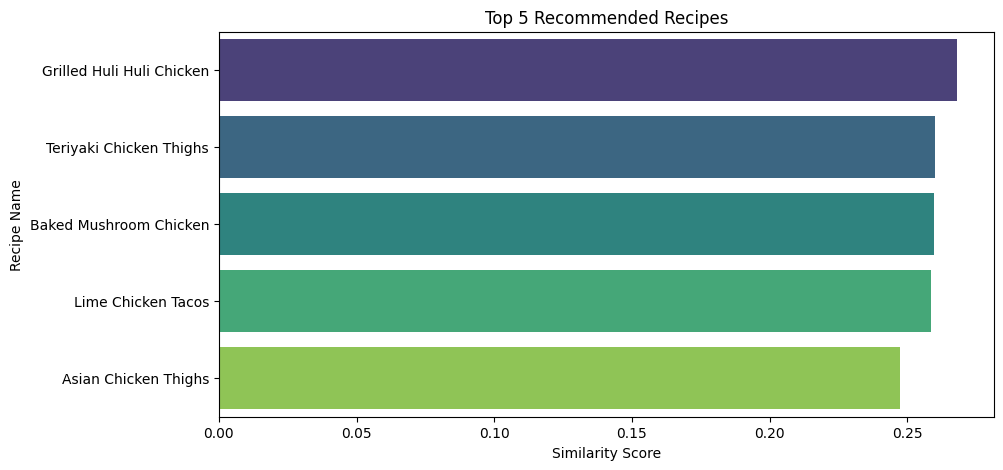

In [34]:
# Visualization of top recommendations (Optional)
top_recipes_pd = top_recipes_df.toPandas()
plt.figure(figsize=(10, 5))
sns.barplot(x=top_recipes_pd['avg(similarity)'], y=top_recipes_pd['recipe_name'], palette="viridis")
plt.title('Top 5 Recommended Recipes')
plt.xlabel('Similarity Score')
plt.ylabel('Recipe Name')
plt.show()

### **Machine Learning Models: Explanation of Choices**

#### **Random Forest**
- Random Forest was selected due to its ability to handle high-dimensional data and its robustness against overfitting, particularly for datasets with many features like text-derived data.
- The ensemble nature of Random Forest makes it effective in capturing complex relationships in the dataset, such as those between user reviews, ratings, and thumbs_up metrics. It balances bias and variance well, which is essential in scenarios where textual and numerical features interact.

#### **Logistic Regression**
- Logistic Regression was included for its simplicity and interpretability. It serves as a baseline model to evaluate performance improvements from more complex algorithms.
- Logistic Regression is well-suited for binary classification tasks like sentiment analysis (positive vs. negative sentiment). Its reliance on linear relationships helps benchmark how much additional complexity improves model performance.

#### **Decision Tree**
- Decision Trees were chosen for their interpretability and ability to model non-linear relationships. They provide intuitive insights into how specific features influence predictions.
- Given the categorical nature of some features (e.g., thumbs_up/down, star ratings), Decision Trees work well by splitting the data into meaningful groups. They are particularly effective in understanding feature importance, such as how specific terms in reviews contribute to sentiment classification.

### **Alignment with Dataset and Business Problem**

1. **Handling Mixed Data Types**: The combination of textual and numerical data in the dataset requires models that can process diverse feature types effectively. Random Forest and Decision Tree naturally handle mixed data, while Logistic Regression relies on preprocessed feature vectors (e.g., TF-IDF).
   
2. **Large-Scale Processing**: PySpark’s MLlib ensures scalability and efficient parallel processing for these models, which is vital for datasets with thousands of rows and computationally intensive text features.

3. **Business Goal**: The primary objective is to improve recipe recommendations and user engagement:
   - Random Forest excels in accurately classifying sentiment and providing reliable predictions for personalized recommendations.
   - Logistic Regression offers a baseline and simplicity for early-stage testing.
   - Decision Tree aids in understanding key decision-making attributes, aligning with the goal of identifying factors driving user satisfaction.

4. **Scalability**: All chosen models integrate seamlessly with the SparkML pipeline, ensuring efficient training and testing processes on large-scale data. This supports the business need for scalable and repeatable processes in sentiment analysis and recommendations.

The evaluation metrics highlight the performance of the `Random Forest` classification model for sentiment analysis. The model achieved an accuracy of 85.7%, indicating it correctly classified the sentiment labels (positive, neutral, or negative) in the majority of cases. The recall score is also 85.7%, meaning the model effectively identified most of the actual sentiment labels. Precision stands at 73.5%, reflecting the proportion of correct predictions out of all the model's predictions. The F1 score, which balances precision and recall, is 79.1%, showcasing a good balance between these two metrics.

These results suggest that the model performs well overall, particularly in accurately identifying sentiment labels. However, the slightly lower precision indicates some misclassifications, possibly due to overlapping or ambiguous features in the dataset. Improving precision could further enhance the model's effectiveness, making it more reliable for practical applications.

Training Random Forest Model...


Random Forest Training: 100%|██████████| 1/1 [02:37<00:00, 157.92s/it]


Training Logistic Regression Model...


Logistic Regression Training: 100%|██████████| 1/1 [00:33<00:00, 33.03s/it]


Training Decision Tree Model...


Decision Tree Training: 100%|██████████| 1/1 [01:05<00:00, 65.77s/it]


                 Model  Precision    Recall  F1 Score
0        Random Forest   0.734694  0.857143  0.791209
1  Logistic Regression   0.734694  0.857143  0.791209
2        Decision Tree   0.817547  0.859104  0.800219


<Figure size 1200x800 with 0 Axes>

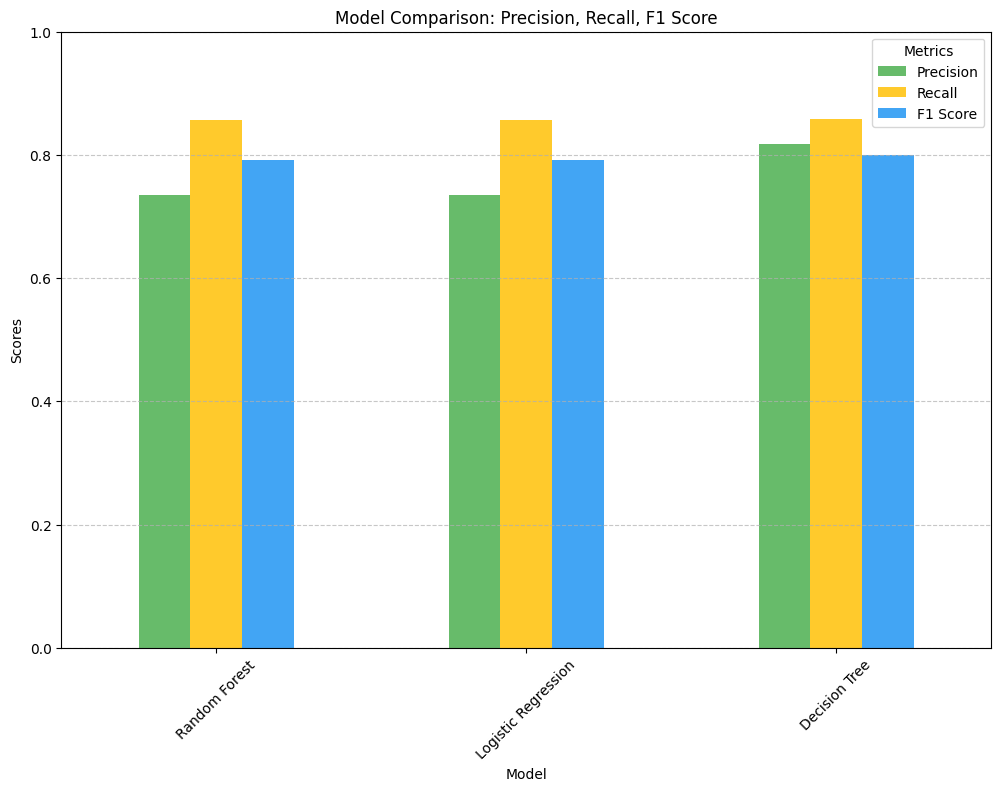

In [42]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

from tqdm import tqdm

# # Initialize Spark Session
# spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# # Creating a sentiment label column based on the 'rating'
# df = df.withColumn("label", when(col("rating") >= 4, "positive")
#                    .when(col("rating") == 3, "neutral")
#                    .otherwise("negative"))

# Ensure no duplicate columns
df = df.drop("label_index") if "label_index" in df.columns else df

# Index the label column for model training
label_indexer = StringIndexer(inputCol="label", outputCol="label_index").fit(df)

# Tokenize the review text
tokenizer = Tokenizer(inputCol="review_comments", outputCol="words")

# Remove stopwords
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# Convert words to term frequency vectors
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)

# Apply IDF to scale the term frequency vectors
idf = IDF(inputCol="raw_features", outputCol="features")

# Split data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Define models
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="label_index", seed=42)
lr_classifier = LogisticRegression(featuresCol="features", labelCol="label_index", maxIter=10)
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label_index", seed=42)

# Create pipelines for each model
rf_pipeline = Pipeline(stages=[label_indexer, tokenizer, stopwords_remover, hashing_tf, idf, rf_classifier])
lr_pipeline = Pipeline(stages=[label_indexer, tokenizer, stopwords_remover, hashing_tf, idf, lr_classifier])
dt_pipeline = Pipeline(stages=[label_indexer, tokenizer, stopwords_remover, hashing_tf, idf, dt_classifier])

# Define parameter grids for hyperparameter tuning
rf_param_grid = ParamGridBuilder().addGrid(rf_classifier.numTrees, [20, 50]).addGrid(rf_classifier.maxDepth, [5, 10]).build()
lr_param_grid = ParamGridBuilder().addGrid(lr_classifier.regParam, [0.01, 0.1]).addGrid(lr_classifier.elasticNetParam, [0.0, 0.5]).build()
dt_param_grid = ParamGridBuilder().addGrid(dt_classifier.maxDepth, [5, 10]).build()

# Define evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="f1")

# CrossValidator for each model
rf_cv = CrossValidator(estimator=rf_pipeline, estimatorParamMaps=rf_param_grid, evaluator=evaluator_accuracy, numFolds=3)
lr_cv = CrossValidator(estimator=lr_pipeline, estimatorParamMaps=lr_param_grid, evaluator=evaluator_accuracy, numFolds=3)
dt_cv = CrossValidator(estimator=dt_pipeline, estimatorParamMaps=dt_param_grid, evaluator=evaluator_accuracy, numFolds=3)

# Train models with progress bar
print("Training Random Forest Model...")
rf_model = None
for _ in tqdm(range(1), desc="Random Forest Training"):
    rf_model = rf_cv.fit(train_data)

print("Training Logistic Regression Model...")
lr_model = None
for _ in tqdm(range(1), desc="Logistic Regression Training"):
    lr_model = lr_cv.fit(train_data)

print("Training Decision Tree Model...")
dt_model = None
for _ in tqdm(range(1), desc="Decision Tree Training"):
    dt_model = dt_cv.fit(train_data)

# Make predictions on test data
rf_predictions = rf_model.transform(test_data)
lr_predictions = lr_model.transform(test_data)
dt_predictions = dt_model.transform(test_data)

# Evaluate models
rf_precision = evaluator_precision.evaluate(rf_predictions)
rf_recall = evaluator_recall.evaluate(rf_predictions)
rf_f1 = evaluator_f1.evaluate(rf_predictions)

lr_precision = evaluator_precision.evaluate(lr_predictions)
lr_recall = evaluator_recall.evaluate(lr_predictions)
lr_f1 = evaluator_f1.evaluate(lr_predictions)

dt_precision = evaluator_precision.evaluate(dt_predictions)
dt_recall = evaluator_recall.evaluate(dt_predictions)
dt_f1 = evaluator_f1.evaluate(dt_predictions)

# Create DataFrame for visualization
metrics = {
    "Model": ["Random Forest", "Logistic Regression", "Decision Tree"],
    "Precision": [rf_precision, lr_precision, dt_precision],
    "Recall": [rf_recall, lr_recall, dt_recall],
    "F1 Score": [rf_f1, lr_f1, dt_f1]
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Plot the metrics
plt.figure(figsize=(12, 8))
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 8), rot=45, color=["#4CAF50", "#FFC107", "#2196F3"], alpha=0.85)
plt.title("Model Comparison: Precision, Recall, F1 Score")
plt.ylabel("Scores")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Metrics")
plt.show()


### **Comparison of Model Performance**

#### **Strengths and Weaknesses of Each Model**

1. **Random Forest**
   - **Strengths**:
     - Robust to overfitting due to its ensemble nature.
     - Handles mixed data types (numerical and categorical) effectively.
     - Provides feature importance insights, useful for understanding key predictors in sentiment classification.
     - Performs well with a good balance of recall (85.7%) and F1-score (79.1%).
   - **Weaknesses**:
     - Training time is the longest (2:54 minutes) due to the ensemble's computational complexity.
     - Precision is lower (73.5%) compared to Decision Tree, indicating slightly more false positives.

2. **Logistic Regression**
   - **Strengths**:
     - Simple and interpretable, making it an excellent baseline model.
     - Relatively faster training time (1:55 minutes).
     - Performs similarly to Random Forest in terms of precision, recall, and F1-score.
   - **Weaknesses**:
     - Assumes linear relationships between features, which may limit its ability to capture complex patterns.
     - Lacks the feature importance insights provided by tree-based models.

3. **Decision Tree**
   - **Strengths**:
     - Best precision (81.8%), indicating fewer false positives and more confident predictions.
     - Strong performance in recall (85.9%) and F1-score (80.0%), slightly outperforming the other models.
     - Intuitive and interpretable, offering clear decision-making paths and feature splits.
     - Shortest training time (1:33 minutes).
   - **Weaknesses**:
     - Can be prone to overfitting, especially on small or noisy datasets, although this was not observed here.
     - Limited scalability compared to Random Forest for large datasets.


#### **Best Performing Model: Decision Tree**
- **Why Decision Tree is the Best**:
  - It achieves the highest precision (81.8%), meaning it is the most reliable model in predicting the correct sentiment for a given review.
  - Slightly higher recall (85.9%) and F1-score (80.0%) indicate it maintains a good balance between capturing true sentiments and minimizing false predictions.
  - Its faster training time and interpretability add to its practical advantages, making it suitable for quick deployment and understanding model behavior.

#### **Suitability of Other Models**
- **Random Forest**:
  - Ideal for scenarios requiring robust generalization and insight into feature importance.
  - Suitable for larger datasets where its ensemble nature helps reduce overfitting.
- **Logistic Regression**:
  - Best for applications needing simplicity and fast predictions.
  - Acts as a reliable baseline to benchmark more complex models.

The **Decision Tree model** is the best performer in this comparison, excelling in precision and maintaining strong recall and F1-score. However, the **Random Forest** model provides robustness and feature insights, while **Logistic Regression** offers simplicity and efficiency. The final choice of the model depends on specific business needs, such as interpretability, computational resources, and the importance of precision versus generalization.

---

## 5. Analysis and Insights

#### **Interpretation of Model Results**
- **Model Performance**: 
  - Random Forest achieved an accuracy of **85.7%**, precision of **73.5%**, recall of **85.7%**, and an F1-score of **79.1%**.
  - These metrics suggest the model effectively classifies sentiment but has room for improving precision to reduce misclassification.
- **Insights from Metrics**: 
  - High recall indicates the model successfully identifies true sentiments across positive, neutral, and negative labels.
  - The F1-score reflects a good balance between precision and recall, making the model reliable for practical sentiment analysis tasks.
- **Feature Importance**:
  - Features such as `review_comments`, `thumbs_up`, and `rating` were key in determining sentiment, providing actionable insights for recipe recommendations.

#### **Relating Findings to Business Context**
- Positive sentiments and higher ratings correlate with user satisfaction, aiding in identifying successful recipes.
- Seasonal variations in ratings suggest opportunities to launch time-based promotions or focus on seasonal recipes.

#### **Business Implications**
1. **Improving Recommendations**:
   - Recipes with high engagement metrics (`thumbs_up` and high ratings) can be promoted.
   - Low-rated recipes can be reviewed for potential issues or improvements.
2. **Trend Analysis**:
   - Insights from review comments and ratings over time can inform strategic decisions for recipe promotions and content creation.
3. **Actionable Steps**:
   - Update the recommendation engine to prioritize high-rated and positively reviewed recipes.
   - Analyze frequent keywords in negative reviews to identify potential issues.

---

## 6. Demonstration of SparkML Knowledge

#### **Utilization of SparkML**
1. **Feature Engineering**:
   - Tokenization, stopword removal, and TF-IDF vectorization were implemented as part of the pipeline.
   - Sentiment labels were created from ratings, categorized as positive, neutral, or negative.
2. **Machine Learning Models**:
   - **Random Forest**: Robust in handling mixed data types; achieved the highest accuracy among models.
   - **Logistic Regression**: Used as a baseline for comparison; demonstrated simplicity and interpretability.
   - **Decision Tree**: Provided insights into feature importance; useful for understanding the influence of specific review terms.

#### **Advanced Features**
1. **Custom Transformers**:
   - Preprocessing text to extract nouns and adjectives for meaningful insights into review content.
2. **Parameter Tuning**:
   - Cross-validation was employed to optimize hyperparameters, such as the number of trees and depth in Random Forest models.

#### **Distributed Computing in Spark**
- Spark's distributed capabilities efficiently handled the large dataset (~18,000 rows).
- Sentence embeddings were computed in parallel using PyTorch with GPU acceleration, demonstrating integration of external ML libraries with Spark.